# Arixiv Search with OpenCLIP and LanceDB

In this example we'll build a Arxiv Search or a recommender based on semantic search using LanceDB. We'll also compare the results with keyword based saerch on Nomic's atlast


## OpenCLIP

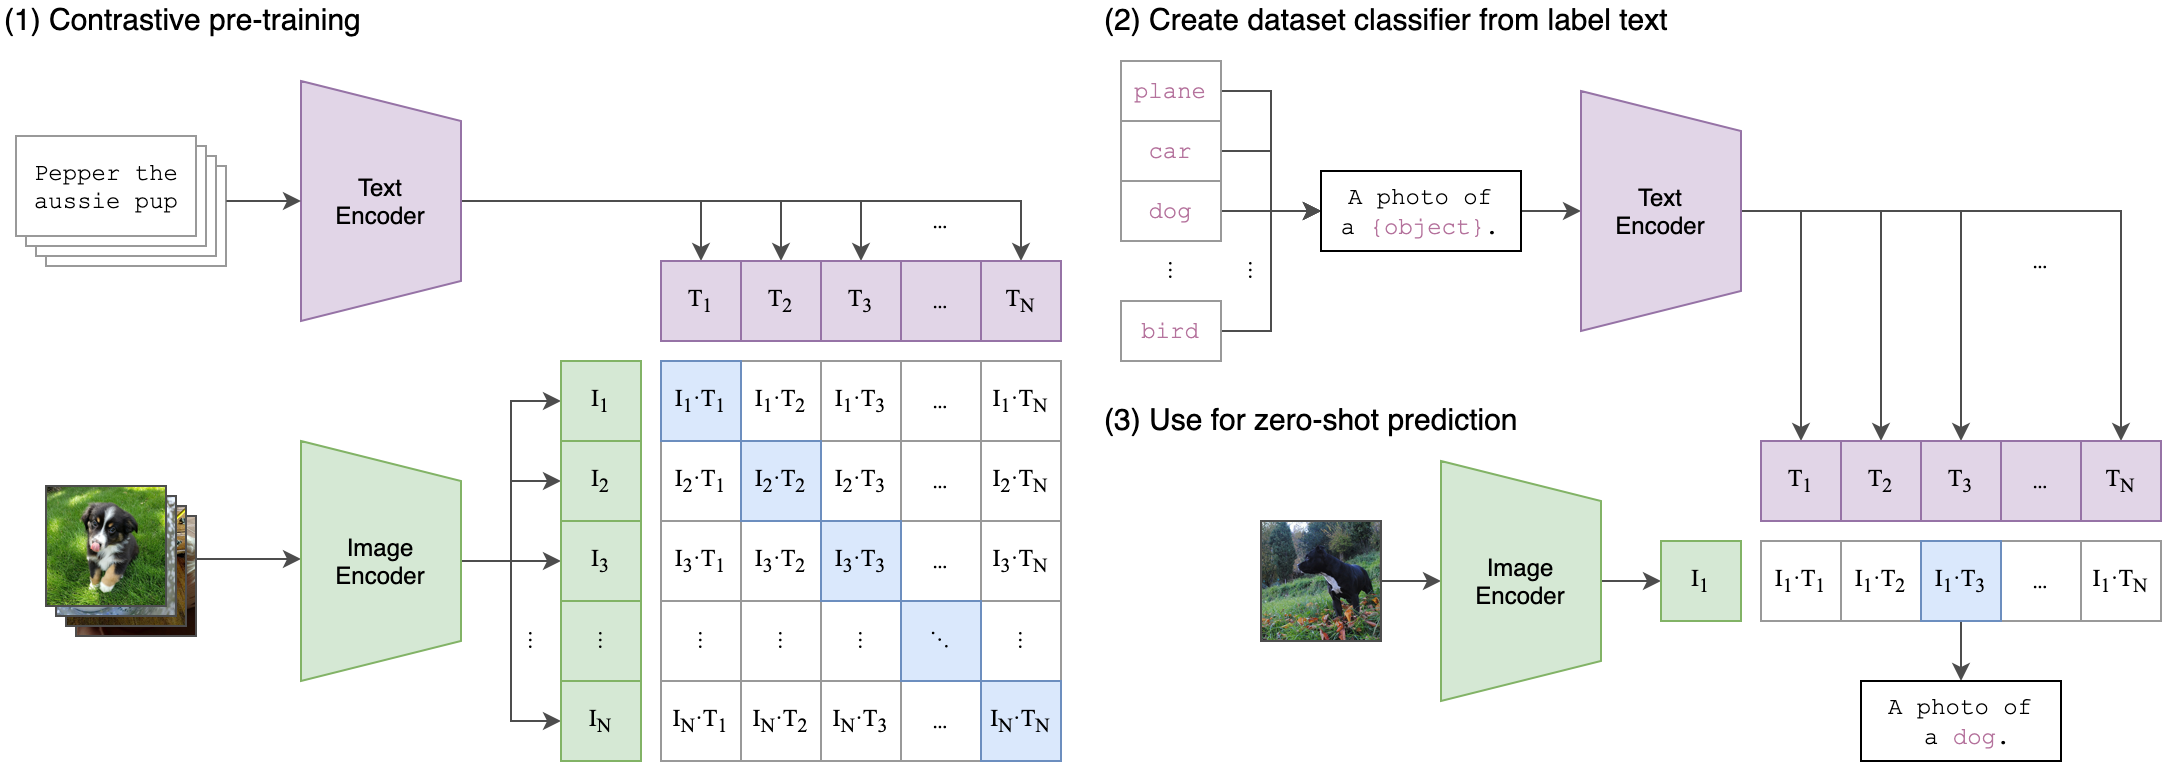

OpenCLIP an open source implementation of OpenAI's CLIP (Contrastive Language-Image Pre-training) as is available with various backends

In [8]:
# SETUP
!pip install lancedb open_clip_torch arxiv --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=294e6b709120203187d4be5f4d77a118173b88d4feee49642595b3060423a544
  Stored in directory: /private/tmp/pip-ephem-wheel-cache-dyw0r0kc/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Creating table from arxiv API

### Embedding Paper Summary using CLIP


In [1]:
import torch
import open_clip
import pandas as pd
from open_clip import tokenizer
from tqdm import tqdm
from collections import defaultdict
import arxiv
import lancedb

def embed_func_clip(text):
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    with torch.no_grad():
        text_features = model.encode_text(tokenizer(text))
    return text_features

/Users/ayushchaurasia/Documents/vectordb-recipes/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a DataFrame of the desired length

Here we'll use arxiv python utility to interact with arxiv api and get the document data

In [2]:
def get_arxiv_df(embed_func, length=10000):
    results = arxiv.Search(
      query= "cat:cs.AI OR cat:cs.CV OR cat:stat.ML",
      max_results = length,
      sort_by = arxiv.SortCriterion.Relevance,
      sort_order = arxiv.SortOrder.Descending
    ).results()
    df = defaultdict(list)
    for result in tqdm(results, total=length):
        try:
            df["title"].append(result.title)
            df["summary"].append(result.summary)
            df["authors"].append(str(result.authors))
            df["url"].append(result.entry_id)
            df["vector"].append(embed_func(result.summary).tolist()[0])

        except Exception as e:
            print("error: ", e)
    
    return pd.DataFrame(df)



In [3]:
LENGTH = 10000 # Reduce the size for demo
def create_table():
    db = lancedb.connect("db")
    df = get_arxiv_df(embed_func_clip)

    tbl = db.create_table("arxiv", data=df, mode="overwrite")

    return tbl

In [4]:
import lancedb
import build_table # helper local module

db = lancedb.connect("db")

if "arxiv" not in db.table_names():
    tbl = create_table()
else:
    tbl = db.open_table("arxiv")


## Semantic Search by concepts or summary

In [28]:
from IPython.display import display, HTML

def search_table(query, embed_func=embed_func_clip, lim=3):
    db = lancedb.connect("db")
    tbl = db.open_table("arxiv")

    embs = embed_func(query)
    
    return tbl.search(embs.tolist()[0]).limit(3).to_df()


In [32]:
# MobileSAM paper abstract 2nd half
query = """
Many of such applications need to be run on resource-constraint edge devices,
like mobile phones. In this work, we aim to make SAM mobile-friendly by replacing the heavyweight
image encoder with a lightweight one. A naive way to train such a new SAM as in the original SAM
paper leads to unsatisfactory performance, especially when limited training sources are available. We
find that this is mainly caused by the coupled optimization of the image encoder and mask decoder,
motivated by which we propose decoupled distillation. Concretely, we distill the knowledge from
the heavy image encoder (ViT-H in the original SAM) to a lightweight image encoder, which can be
automatically compatible with the mask decoder in the original SAM. The training can be completed
on a single GPU within less than one day, and the resulting lightweight SAM is termed MobileSAM
which is more than 60 times smaller yet performs on par with the original SAM. For inference speed,
With a single GPU, MobileSAM runs around 10ms per image: 8ms on the image encoder and 4ms
on the mask decoder. With superior performance, our MobileSAM is around 5 times faster than the
concurrent FastSAM and 7 times smaller, making it more suitable for mobile applications. Moreover,
we show that MobileSAM can run relatively smoothly on CPU
"""

result = search_table(query)

result.pop("vector")
display(HTML(result.to_html()))


,title,summary,authors,url,score
0,Can SAM Count Anything? An Empirical Study on SAM Counting,"Meta AI recently released the Segment Anything model (SAM), which has\ngarnered attention due to its impressive performance in class-agnostic\nsegmenting. In this study, we explore the use of SAM for the challenging task\nof few-shot object counting, which involves counting objects of an unseen\ncategory by providing a few bounding boxes of examples. We compare SAM's\nperformance with other few-shot counting methods and find that it is currently\nunsatisfactory without further fine-tuning, particularly for small and crowded\nobjects. Code can be found at\n\url{https://github.com/Vision-Intelligence-and-Robots-Group/count-anything}.","[arxiv.Result.Author('Zhiheng Ma'), arxiv.Result.Author('Xiaopeng Hong'), arxiv.Result.Author('Qinnan Shangguan')]",http://arxiv.org/abs/2304.10817v1,35.039112
1,Communication-Computation Efficient Device-Edge Co-Inference via AutoML,"Device-edge co-inference, which partitions a deep neural network between a\nresource-constrained mobile device and an edge server, recently emerges as a\npromising paradigm to support intelligent mobile applications. To accelerate\nthe inference process, on-device model sparsification and intermediate feature\ncompression are regarded as two prominent techniques. However, as the on-device\nmodel sparsity level and intermediate feature compression ratio have direct\nimpacts on computation workload and communication overhead respectively, and\nboth of them affect the inference accuracy, finding the optimal values of these\nhyper-parameters brings a major challenge due to the large search space. In\nthis paper, we endeavor to develop an efficient algorithm to determine these\nhyper-parameters. By selecting a suitable model split point and a pair of\nencoder/decoder for the intermediate feature vector, this problem is casted as\na sequential decision problem, for which, a novel automated machine learning\n(AutoML) framework is proposed based on deep reinforcement learning (DRL).\nExperiment results on an image classification task demonstrate the\neffectiveness of the proposed framework in achieving a better\ncommunication-computation trade-off and significant inference speedup against\nvarious baseline schemes.","[arxiv.Result.Author('Xinjie Zhang'), arxiv.Result.Author('Jiawei Shao'), arxiv.Result.Author('Yuyi Mao'), arxiv.Result.Author('Jun Zhang')]",http://arxiv.org/abs/2108.13009v2,35.435425
2,Saliency Prediction for Mobile User Interfaces,"We introduce models for saliency prediction for mobile user interfaces. A\nmobile interface may include elements like buttons, text, etc. in addition to\nnatural images which enable performing a variety of tasks. Saliency in natural\nimages is a well studied area. However, given the difference in what\nconstitutes a mobile interface, and the usage context of these devices, we\npostulate that saliency prediction for mobile interface images requires a fresh\napproach. Mobile interface design involves operating on elements, the building\nblocks of the interface. We first collected eye-gaze data from mobile devices\nfor free viewing task. Using this data, we develop a novel autoencoder based\nmulti-scale deep learning model that provides saliency prediction at the mobile\ninterface element level. Compared to saliency prediction approaches developed\nfor natural images, we show that our approach performs significantly better on\na range of established metrics.","[arxiv.Result.Author('Prakhar Gupta'), arxiv.Result.Author('Shubh Gupta'), arxiv.Result.Author('Ajaykrishnan Jayagopal'), arxiv.Result.Author('Sourav Pal'), arxiv.Result.Author('Ritwik Sinha')]",http://arxiv.org/abs/1711.03726v3,36.065895


In [33]:
# Exmaple 2: Search via a concept you're reading
query = """
What is the general idea behind self-supervised learning.
"""

result = search_table(query)

result.pop("vector")
display(HTML(result.to_html()))


,title,summary,authors,url,score
0,Towards the Generalization of Contrastive Self-Supervised Learning,"Recently, self-supervised learning has attracted great attention, since it\nonly requires unlabeled data for model training. Contrastive learning is one\npopular method for self-supervised learning and has achieved promising\nempirical performance. However, the theoretical understanding of its\ngeneralization ability is still limited. To this end, we define a kind of\n$(\sigma,\delta)$-measure to mathematically quantify the data augmentation, and\nthen provide an upper bound of the downstream classification error rate based\non the measure. It reveals that the generalization ability of contrastive\nself-supervised learning is related to three key factors: alignment of positive\nsamples, divergence of class centers, and concentration of augmented data. The\nfirst two factors are properties of learned representations, while the third\none is determined by pre-defined data augmentation. We further investigate two\ncanonical contrastive losses, InfoNCE and cross-correlation, to show how they\nprovably achieve the first two factors. Moreover, we conduct experiments to\nstudy the third factor, and observe a strong correlation between downstream\nperformance and the concentration of augmented data.","[arxiv.Result.Author('Weiran Huang'), arxiv.Result.Author('Mingyang Yi'), arxiv.Result.Author('Xuyang Zhao'), arxiv.Result.Author('Zihao Jiang')]",http://arxiv.org/abs/2111.00743v4,23.513828
1,Efficient Self-supervised Continual Learning with Progressive Task-correlated Layer Freezing,"Inspired by the success of Self-supervised learning (SSL) in learning visual\nrepresentations from unlabeled data, a few recent works have studied SSL in the\ncontext of continual learning (CL), where multiple tasks are learned\nsequentially, giving rise to a new paradigm, namely self-supervised continual\nlearning (SSCL). It has been shown that the SSCL outperforms supervised\ncontinual learning (SCL) as the learned representations are more informative\nand robust to catastrophic forgetting. However, if not designed intelligently,\nthe training complexity of SSCL may be prohibitively high due to the inherent\ntraining cost of SSL. In this work, by investigating the task correlations in\nSSCL setup first, we discover an interesting phenomenon that, with the\nSSL-learned background model, the intermediate features are highly correlated\nbetween tasks. Based on this new finding, we propose a new SSCL method with\nlayer-wise freezing which progressively freezes partial layers with the highest\ncorrelation ratios for each task to improve training computation efficiency and\nmemory efficiency. Extensive experiments across multiple datasets are\nperformed, where our proposed method shows superior performance against the\nSoTA SSCL methods under various SSL frameworks. For example, compared to LUMP,\nour method achieves 12\%/14\%/12\% GPU training time reduction, 23\%/26\%/24\%\nmemory reduction, 35\%/34\%/33\% backward FLOPs reduction, and\n1.31\%/1.98\%/1.21\% forgetting reduction without accuracy degradation on three\ndatasets, respectively.","[arxiv.Result.Author('Li Yang'), arxiv.Result.Author('Sen Lin'), arxiv.Result.Author('Fan Zhang'), arxiv.Result.Author('Junshan Zhang'), arxiv.Result.Author('Deliang Fan')]",http://arxiv.org/abs/2303.07477v1,27.160683
2,Local Aggregation for Unsupervised Learning of Visual Embeddings,"Unsupervised approaches to learning in neural networks are of substantial\ninterest for furthering artificial intelligence, both because they would enable\nthe training of networks without the need for large numbers of expensive\nannotations, and because they would be better models of the kind of\ngeneral-purpose learning deployed by humans. However, unsupervised networks\nhave long lagged behind the performance of their supervised counterparts,\nespecially in the domain of large-scale visual recognition. Recent developments\nin training d

# Full Text Search
In text retrieval, full-text search refers to techniques for searching a single computer-stored document or a collection in a full-text database. Full-text search is distinguished from searches based on metadata or on parts of the original texts represented in databases

LanceDB now provides **experimental** support for full text search. This is currently Python only. We plan to push the integration down to Rust in the future to make this available for JS as well.


In [9]:
!pip install tantivy@git+https://github.com/quickwit-oss/tantivy-py#164adc87e1a033117001cf70e38c82a53014d985

  Cloning https://github.com/quickwit-oss/tantivy-py to /private/tmp/pip-install-ztjpbabu/tantivy_0f04885d805b4c67b5557e67675cf5a5
  Running command git clone --filter=blob:none --quiet https://github.com/quickwit-oss/tantivy-py /private/tmp/pip-install-ztjpbabu/tantivy_0f04885d805b4c67b5557e67675cf5a5
  Resolved https://github.com/quickwit-oss/tantivy-py to commit f12bac1f973adf176a535ee637bbb69941216b61
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


### Build FTS index for the summary
Here, we're building the FTS index using python bindings for tantivy. You can also build the index for any other text column. A full-text index stores information about significant words and their location within one or more columns of a database table

In [11]:
# This cell might take a few mins
tbl.create_fts_index("summary")


In [34]:
## FTS via title
result = tbl.search("What is the general idea behind self-supervised learning.").limit(10).to_df()

result.pop("vector")

display(HTML(result.to_html()))

,title,summary,authors,url,score
0,On Feature Decorrelation in Self-Supervised Learning,"In self-supervised representation learning, a common idea behind most of the\nstate-of-the-art approaches is to enforce the robustness of the representations\nto predefined augmentations. A potential issue of this idea is the existence of\ncompletely collapsed solutions (i.e., constant features), which are typically\navoided implicitly by carefully chosen implementation details. In this work, we\nstudy a relatively concise framework containing the most common components from\nrecent approaches. We verify the existence of complete collapse and discover\nanother reachable collapse pattern that is usually overlooked, namely\ndimensional collapse. We connect dimensional collapse with strong correlations\nbetween axes and consider such connection as a strong motivation for feature\ndecorrelation (i.e., standardizing the covariance matrix). The gains from\nfeature decorrelation are verified empirically to highlight the importance and\nthe potential of this insight.","[arxiv.Result.Author('Tianyu Hua'), arxiv.Result.Author('Wenxiao Wang'), arxiv.Result.Author('Zihui Xue'), arxiv.Result.Author('Sucheng Ren'), arxiv.Result.Author('Yue Wang'), arxiv.Result.Author('Hang Zhao')]",http://arxiv.org/abs/2105.00470v2,16.563347
1,Architecture-Agnostic Masked Image Modeling -- From ViT back to CNN,"Masked image modeling, an emerging self-supervised pre-training method, has\nshown impressive success across numerous downstream vision tasks with Vision\ntransformers. Its underlying idea is simple: a portion of the input image is\nmasked out and then reconstructed via a pre-text task. However, the working\nprinciple behind MIM is not well explained, and previous studies insist that\nMIM primarily works for the Transformer family but is incompatible with CNNs.\nIn this work, we observe that MIM essentially teaches the model to learn better\nmiddle-order interactions among patches for more generalized feature\nextraction. We then propose an Architecture-Agnostic Masked Image Modeling\nframework (A$^2$MIM), which is compatible with both Transformers and CNNs in a\nunified way. Extensive experiments on popular benchmarks show that A$^2$MIM\nlearns better representations without explicit design and endows the backbone\nmodel with the stronger capability to transfer to various downstream tasks.","[arxiv.Result.Author('Siyuan Li'), arxiv.Result.Author('Di Wu'), arxiv.Result.Author('Fang Wu'), arxiv.Result.Author('Zelin Zang'), arxiv.Result.Author('Stan. Z. Li')]",http://arxiv.org/abs/2205.13943v4,14.429430
2,Semi-Supervised Learning with Scarce Annotations,"While semi-supervised learning (SSL) algorithms provide an efficient way to\nmake use of both labelled and unlabelled data, they generally struggle when the\nnumber of annotated samples is very small. In this work, we consider the\nproblem of SSL multi-class classification with very few labelled instances. We\nintroduce two key ideas. The first is a simple but effective one: we leverage\nthe power of transfer learning among different tasks and self-supervision to\ninitialize a good representation of the data without making use of any label.\nThe second idea is a new algorithm for SSL that can exploit well such a\npre-trained representation.\n The algorithm works by alternating two phases, one fitting the labelled\npoints and one fitting the unlabelled ones, with carefully-controlled\ninformation flow between them. The benefits are greatly reducing overfitting of\nthe labelled data and avoiding issue with balancing labelled and unlabelled\nlosses during training. We show empirically that this method can successfully\ntrain competitive models with as few as 10 labelled data points per class. More\nin general, we show that the idea of bootstrapping features using\nself-supervised learning always improves SSL on standard benchmarks. We show\nthat our algorithm works increasingly well compared to other methods when\nref

### Analysing OpenCLIP embeddings on Nomic
Atlas is a platform for interacting with both small and internet scale unstructured datasets.

Atlas enables you to:
* Store, update and organize multi-million point datasets of unstructured text, images and embeddings.
* Visually interact with embeddings of your data from a web browser.
* Operate over unstructured data and embeddings with topic modeling, semantic duplicate clustering and semantic search.
* Generate high dimensional and two-dimensional embeddings of your data.

In [14]:
!pip install nomic --q


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [15]:
!nomic login


                        Authenticate with the Nomic API                         
                        https://atlas.nomic.ai/cli-login                        
  Click the above link to retrieve your access token and then run `nomic login  
                                    [token]`                                    


In [16]:
!nomic login #paste token here

In [27]:
from nomic import atlas
import numpy as np

# Get pandas dataframe from lancedb table
df = tbl.to_pandas()

# get embeddings from df
embs = np.array(df.pop("vector").to_list())

project = atlas.map_embeddings(embeddings=embs, data=df.to_dict('records'))
print()

2023-08-23 17:02:34.161 | WARNING  | nomic.atlas:map_embeddings:91 - An ID field was not specified in your data so one was generated for you in insertion order.
2023-08-23 17:02:38.565 | INFO     | nomic.project:_create_project:779 - Creating project `abandoned-kill` in organization `ayush`
2023-08-23 17:02:40.307 | INFO     | nomic.atlas:map_embeddings:107 - Uploading embeddings to Atlas.
7it [00:03,  1.88it/s]                                                                                                                               
2023-08-23 17:02:44.110 | INFO     | nomic.project:_add_data:1411 - Upload succeeded.
2023-08-23 17:02:44.115 | INFO     | nomic.atlas:map_embeddings:126 - Embedding upload succeeded.
2023-08-23 17:02:46.539 | INFO     | nomic.project:create_index:1121 - Created map `abandoned-kill` in project `abandoned-kill`: https://atlas.nomic.ai/map/db61e8d4-bf3c-4702-9573-fa78389de671/a1a55d04-a149-4519-93e3-8ffaae3bc34c
2023-08-23 17:02:46.542 | INFO     | nomic.

[abandoned-kill: https://atlas.nomic.ai/map/db61e8d4-bf3c-4702-9573-fa78389de671/a1a55d04-a149-4519-93e3-8ffaae3bc34c]


The visualizations are very interesting and is worth exploring more. IN preliminary analysis, you can see that it succesfully creates clusters of similar types of papers. There are a few things that can be done next like comparing embeddings on various openclip models sizes and datasets. 
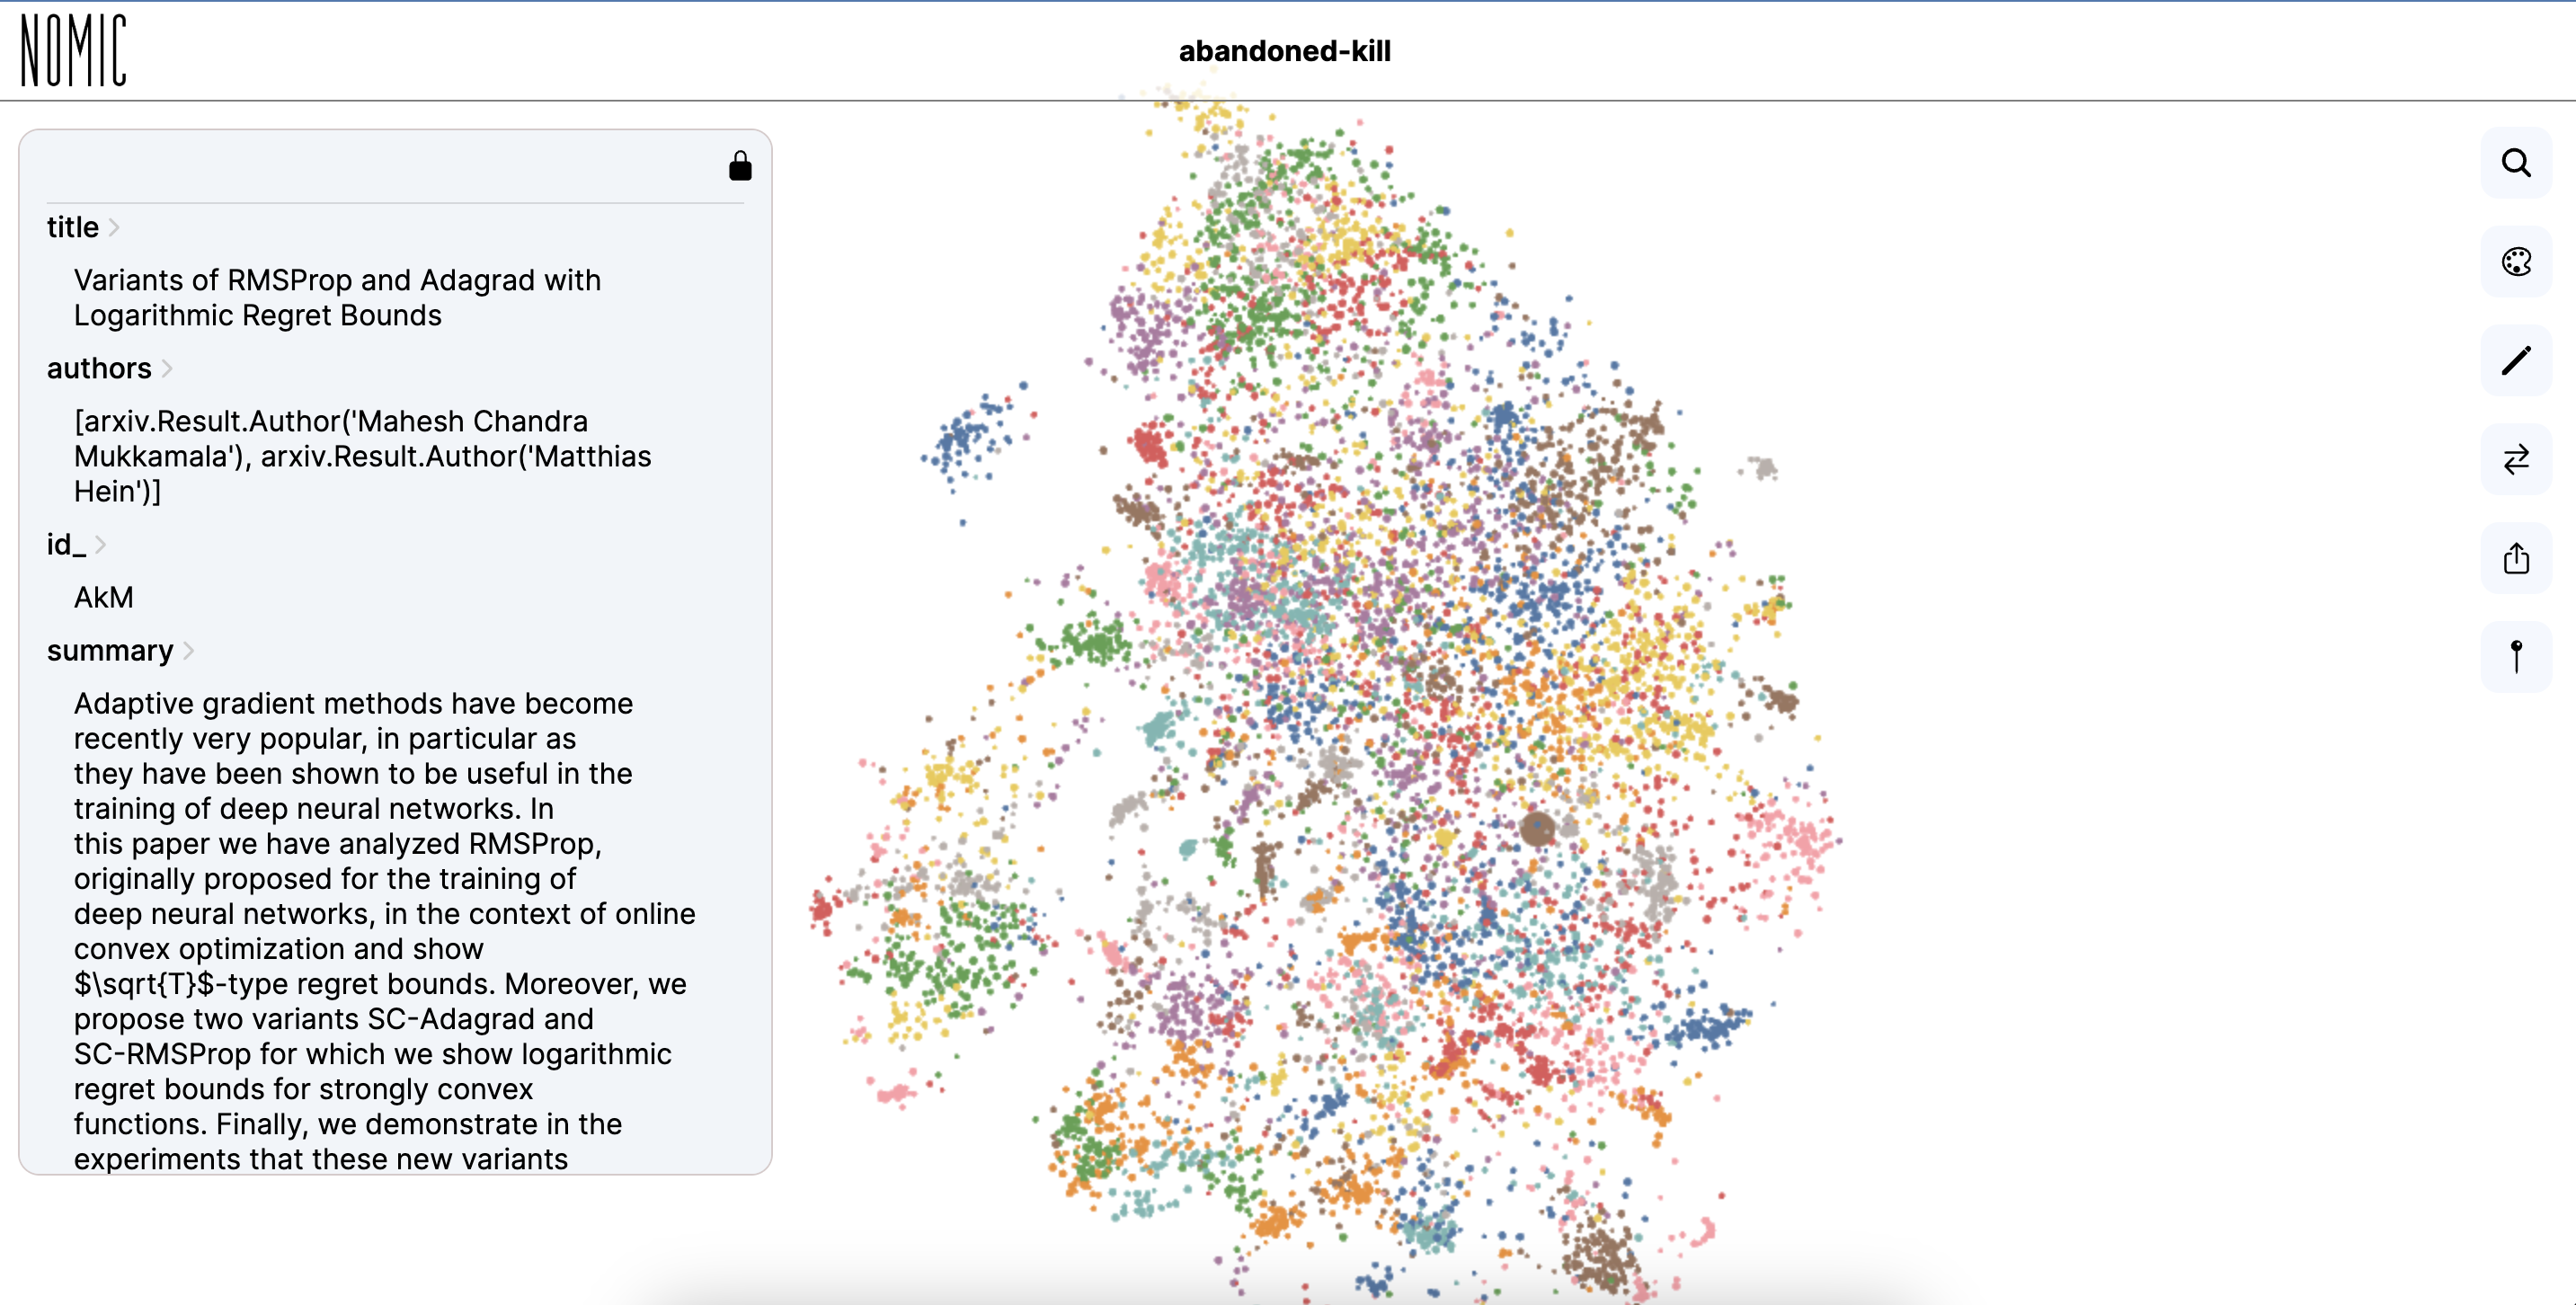